# 3. Model tests
## 3.05 Example: Time delay neural network


Testing the time-delay neural network involves following steps:
1. Load the predictor and predictand arrays (these have been prepared in `2.05_prepare_data_for_the_models`)
3. Define the ML-model
4. Train the model
5. Check the output for errors by visually inspecting timeseries of forecasts.
6. Hyperparameter Optimization
7. Case Study: May/June 2013; Flooding event at Krems (Danube river)
   
   

In [23]:
import sys
sys.path.append("../../")
import numpy as np
import datetime as dt

import matplotlib as mpl
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import pandas as pd
import seaborn as sns
import xarray as xr
import keras

from python.aux.utils_floodmodel import add_time, generate_prediction_array, remove_outlier, multi_forecast_case_study
from python.aux.plot import plot_multif_prediction

## Loading the data
We now load Sample dataset contained in the git repository.

As you are reading these lines, you opened the notebook in the `./docs/` folder of the main repository directory. To access the sample dataset that was delivered to you with the code, step outside the current directory (`../`) and enter the `data/` folder. The names of the sample datasets are `smallsampledata-era5.nc` and `smallsampledata-glofas.nc`, both in netCDF format, a user-friendly format that keeps the file size low and stores meta-data within the file.

We use `xarray` to access the files, as it provides us with a very powerful interface to work with the data. Let's open the files and see what's in there:

In [53]:
# load data
ds = xr.open_dataset('../../data/features_xy.nc')

y_orig = ds['dis']
y = y_orig.copy()
X = ds.drop(['dis', 'dis_diff'])

In [54]:
X

<xarray.Dataset>
Dimensions:     (time: 13514)
Coordinates:
  * time        (time) datetime64[ns] 1981-01-01 1981-01-02 ... 2017-12-31
Data variables:
    cp          (time) float32 ...
    lsp         (time) float32 ...
    swvl1       (time) float32 ...
    ro          (time) float32 ...
    sd          (time) float32 ...
    sd_diff     (time) float32 ...
    lsp-4-11    (time) float32 ...
    lsp-12-25   (time) float32 ...
    lsp-26-55   (time) float32 ...
    lsp-56-180  (time) float32 ...
    lsp-1       (time) float32 ...
    lsp-2       (time) float32 ...
    lsp-3       (time) float32 ...
    cp-1        (time) float32 ...
    cp-2        (time) float32 ...
    cp-3        (time) float32 ...

### Differentiating the predictand
xyz
Predicting just time differences of discharge is the natural way yields a nicer distribution of the predictand so that we can use Mean-Squared-Error as optimization metric. 

mean: 0.0 , std: 269074.8916842176 , skew: 167850422.6997186


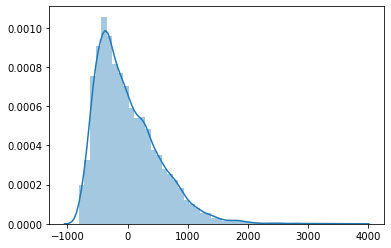

In [55]:
from scipy.stats import moment
dist = y.values.ravel() - y.mean().values.ravel() 
dist = dist[~np.isnan(dist)]
sns.distplot(dist)
print('mean:', moment(dist, 1), ', std:', moment(dist, 2), ', skew:', moment(dist, 3))

mean: 0.0 , std: 4181.27897581471 , skew: 1100883.0967652714


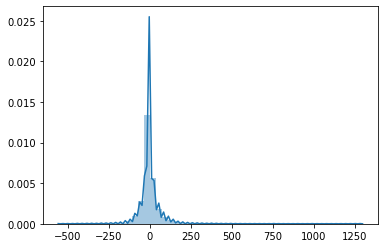

In [56]:
from scipy.stats import moment
dist = y.diff('time', n=1).values.ravel()
dist = dist[~np.isnan(dist)]
sns.distplot(dist)
print('mean:', moment(dist, 1), ', std:', moment(dist, 2), ', skew:', moment(dist, 3))

In [57]:
y = y.diff('time', 1)
y

<xarray.DataArray 'dis' (time: 13513)>
array([-6.15387 ,  4.498413, 17.529724, ..., -4.656921, -2.809204, 20.632019])
Coordinates:
  * time     (time) datetime64[ns] 1981-01-02 1981-01-03 ... 2017-12-31

### Reshaping


In [58]:
from python.aux.utils_floodmodel import reshape_scalar_predictand

In [59]:
Xda, yda = reshape_scalar_predictand(X, y)
Xda.features

<xarray.DataArray 'features' (features: 16)>
array([('cp',), ('lsp',), ('swvl1',), ('ro',), ('sd',), ('sd_diff',),
       ('lsp-4-11',), ('lsp-12-25',), ('lsp-26-55',), ('lsp-56-180',),
       ('lsp-1',), ('lsp-2',), ('lsp-3',), ('cp-1',), ('cp-2',), ('cp-3',)],
      dtype=object)
Coordinates:
  * features  (features) object ('cp',) ('lsp',) ... ('cp-2',) ('cp-3',)

---

Next, we split the dataset into three parts for 
- training (the longest period for estimating the free parameters within the model), 
- validation (for tuning hyperparameters) and 
- testing (for the model comparison).

In [61]:
period_train = dict(time=slice(None, '2005'))
period_valid = dict(time=slice('2006', '2011'))
period_test = dict(time=slice('2012', '2016'))

In [62]:
X_train, y_train = Xda.loc[period_train], yda.loc[period_train]
X_valid, y_valid = Xda.loc[period_valid], yda.loc[period_valid]
X_test, y_test = Xda.loc[period_test], yda.loc[period_test]

In [63]:
X_train.shape, y_train.shape

((8922, 16), (8922,))

In [64]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import keras
from keras.layers.core import Dropout
from keras.constraints import MinMaxNorm, nonneg


def add_time(vector, time, name=None):
    """Converts numpy arrays to xarrays with a time coordinate.

    Parameters
    ----------
    vector : np.array
        1-dimensional array of predictions
    time : xr.DataArray
        the return value of `Xda.time`

    Returns
    -------
    xr.DataArray
    """
    return xr.DataArray(vector, dims=('time'), coords={'time': time}, name=name)


class DenseNN(object):
    def __init__(self, **kwargs):
        self.output_dim = kwargs.pop('output_dim', 1)
        self.xscaler = StandardScaler()
        self.yscaler = StandardScaler()
        
        model = keras.models.Sequential()
        self.cfg = kwargs
        hidden_nodes = self.cfg.get('hidden_nodes')
        
        model.add(keras.layers.Dense(hidden_nodes[0], 
                                     activation='tanh'))
        model.add(keras.layers.BatchNormalization())
        model.add(Dropout(self.cfg.get('dropout', None)))
        
        for n in hidden_nodes[1:]:
            model.add(keras.layers.Dense(n, activation='tanh')) 
            model.add(keras.layers.BatchNormalization())
            model.add(Dropout(self.cfg.get('dropout', None)))
        model.add(keras.layers.Dense(self.output_dim, 
                                     activation='linear'))
        opt = keras.optimizers.Adam() 

        model.compile(loss=self.cfg.get('loss'), optimizer=opt)
        self.model = model

        self.callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss',
                            min_delta=1e-2, patience=100, verbose=0, mode='auto',
                            baseline=None, restore_best_weights=True),]
    
    def score_func(self, X, y):
        """Calculate the RMS error
        
        Parameters
        ----------
        xr.DataArrays
        
        """
        ypred = self.predict(X)
        err_pred = ypred - y
        
        # NaNs do not contribute to error
        err_pred = err_pred.where(~np.isnan(err_pred), 0.)  
        return float(np.sqrt(xr.dot(err_pred, err_pred)))
        
    def predict(self, Xda, name=None):
        """Input and Output: xr.DataArray
        
        Parameters
        ----------
        initial_dis : xr.DataArray
            of shape (init_time,), defines the initial discharge for each sample in `Xda`
        """
        X = self.xscaler.transform(Xda.values)
        y = self.model.predict(X).squeeze()
        y = self.yscaler.inverse_transform(y)
        
        y = add_time(y, Xda.time, name=name)
        return y

    def fit(self, X_train, y_train, X_valid, y_valid, **kwargs):
        """Input: xr.DataArray"""
        
        print(X_train.shape)
        X_train = self.xscaler.fit_transform(X_train.values)
        y_train = self.yscaler.fit_transform(
                        y_train.values.reshape(-1, self.output_dim))
        
        X_valid = self.xscaler.transform(X_valid.values)
        y_valid = self.yscaler.transform(
                        y_valid.values.reshape(-1, self.output_dim))
        
        return self.model.fit(X_train, y_train,
                              validation_data=(X_valid, y_valid), 
                              epochs=self.cfg.get('epochs', 1000),
                              batch_size=self.cfg.get('batch_size'),
                              callbacks=self.callbacks,
                              verbose=0, **kwargs)

In [108]:
config = dict(hidden_nodes=(64,),  
                dropout=0.25,
                epochs=300,
                batch_size=90,
                loss='mse')

m = DenseNN(**config)

In [109]:
hist = m.fit(X_train, y_train, X_valid, y_valid)

(8922, 16)


In [110]:
m.model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 64)                1088      
_________________________________________________________________
batch_normalization_4 (Batch (None, 64)                256       
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 1,409
Trainable params: 1,281
Non-trainable params: 128
_________________________________________________________________


To plot a graph of the network, run the following cell:

The learning curve describes how quickly the optimization of the neural net's parameters converges or if it does not converge at all. The blue line measures the training error and the orange line the validation error. If, at some point, training error but not validation error sinks, the model is overfitting on the training set. 

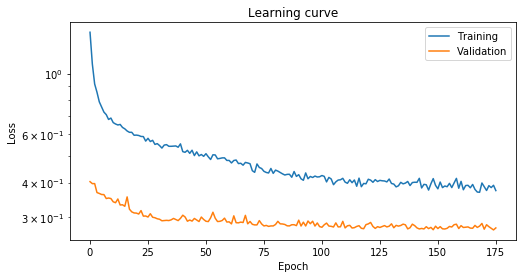

In [111]:
h = hist.model.history

# Plot training & validation loss value
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(h.history['loss'], label='loss')
ax.plot(h.history['val_loss'], label='val_loss')
plt.title('Learning curve')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
plt.legend(['Training', 'Validation'])
ax.set_yscale('log')

In [139]:
import os, yaml
dir_model = '../../models/tdnn-diff-batch90/'
os.makedirs(dir_model, exist_ok=True)

In [ ]:
yaml_string = m.model.to_yaml()
with open(dir_model+'keras-config.yml', 'w') as f:
    yaml.dump(yaml_string, f)
    
with open(dir_model+'model-config.yml', 'w') as f:
    yaml.dump(config, f, indent=4)
    
from contextlib import redirect_stdout
with open(dir_model+'summary.txt', "w") as f:
    with redirect_stdout(f):
        m.model.summary()

In [149]:
y_pred_train = m.predict(X_train)
y_pred_train = generate_prediction_array(y_pred_train, y_orig, forecast_range=14)

y_pred_valid = m.predict(X_valid)
y_pred_valid = generate_prediction_array(y_pred_valid, y_orig, forecast_range=14)

y_pred_test = m.predict(X_test)
y_pred_test = generate_prediction_array(y_pred_test, y_orig, forecast_range=14)

## Results of the Test time-frame

(<Figure size 1080x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f94ad14b5c0>)

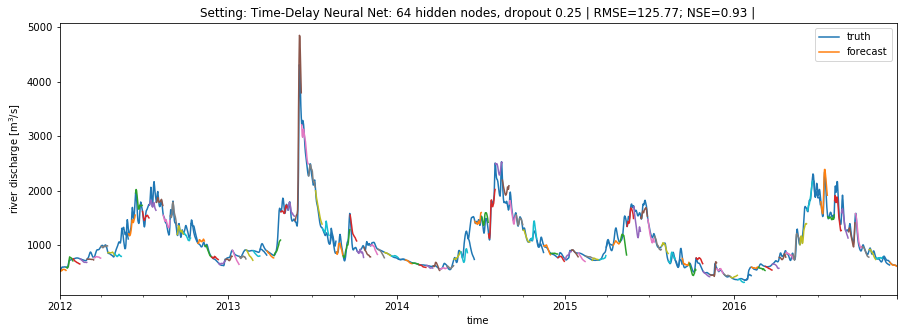

In [203]:
title='Setting: Time-Delay Neural Net: 64 hidden nodes, dropout 0.25'
plot_multif_prediction(y_pred_test, y_orig, forecast_range=14, title=title)

### An interesting case in the Test-Dataset
### The 2013 European Floods



In [199]:
from python.aux.utils_floodmodel import multi_forecast_case_study_tdnn

X_multif_fin, X_multifr_fin, y_case_fin = multi_forecast_case_study_tdnn(m)

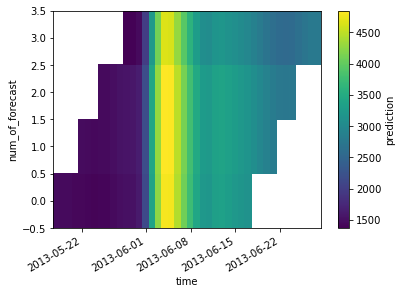

In [200]:
X_multif_fin.plot()

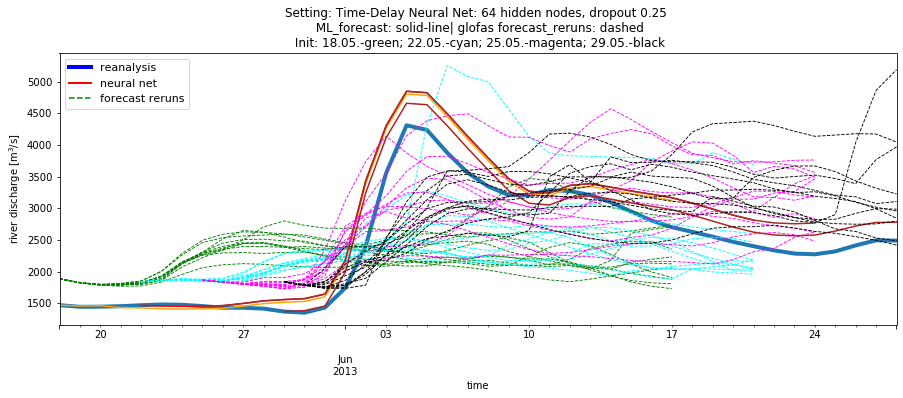

In [229]:
fig, ax = plt.subplots(figsize=(15, 5))
color_scheme = [['orange', 'r', 'brown', 'firebrick'],
                ['g', 'cyan', 'magenta', 'k']]

y_case_fin.to_pandas().plot(ax=ax, label='reanalysis', lw=4)
run = 0
for i in X_multifr_fin.num_of_forecast:
    X_multif_fin.sel(num_of_forecast=i).to_pandas().T.plot(ax=ax, label='forecast', color=color_scheme[0][run])
    X_multifr_fin.sel(num_of_forecast=i).to_pandas().T.plot(ax=ax, label='frerun', linewidth=0.9,
                                                            linestyle='--', color=color_scheme[1][run])
    run += 1
ax.set_ylabel('river discharge [m$^3$/s]')

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='b', lw=4),
                Line2D([0], [0], color='r', lw=2),
                Line2D([0], [0], color='g', linestyle='--')]
ax.legend(custom_lines, ['reanalysis', 'neural net', 'forecast reruns'], fontsize=11)

plt.title('Setting: Time-Delay Neural Net: 64 hidden nodes, dropout 0.25 \n ML_forecast: solid-line'
          '| glofas forecast_reruns: dashed\n Init: 18.05.-green; 22.05.-cyan; 25.05.-magenta; 29.05.-black');

Save the predictions to disk.

In [208]:
y_pred_valid.to_netcdf(dir_model+'tdnn_result_validation_period.nc')
y_pred_test.to_netcdf(dir_model+'tdnn_result_test_period.nc')
X_multif_fin.to_netcdf(dir_model+'tdnn_result_case_study.nc')

## Feature importance

To see the contribution of the features to the final prediction, we can compare the model performance with and without the information from some feature by shuffling the rows of the `X` matrix for that feature, that is, the feature is randomized in a way that maintains the true feature value distribution.

This allows us to evaluate the impact of a feature on the model performance without training the model for each feature over and over again. 

In [209]:
import eli5
from eli5.permutation_importance import get_score_importances

In [230]:
base_score, score_decreases = get_score_importances(m.score_func, X_test, y_test, n_iter=5)

In [231]:
importances = score_decreases/np.max(score_decreases)  # normalize

In [239]:
def feature_importance_plot(xda_features, importances):
    # xda_features : xr.DataArray.features
    # score_decreases : list of arrays
    mmin, mmed, mmax = np.min(importances, axis=0), np.median(importances, axis=0), np.max(importances, axis=0)
    
    labels = [e[0] for e in xda_features.values]
    assert len(labels) == len(importances[0])  # one label per entry
    plt.subplots(figsize=(15,5))

    x = np.arange(len(labels)) 
    plt.bar(x, mmed, yerr=(mmed-mmin, mmax-mmed), width = .8, ecolor='black', capsize=8)

    plt.xticks(ticks=x, labels=labels, rotation=20)
    plt.ylabel('normalized importance')
    plt.title('Estimate of Feature Importance by 5 row-wise Permutations')

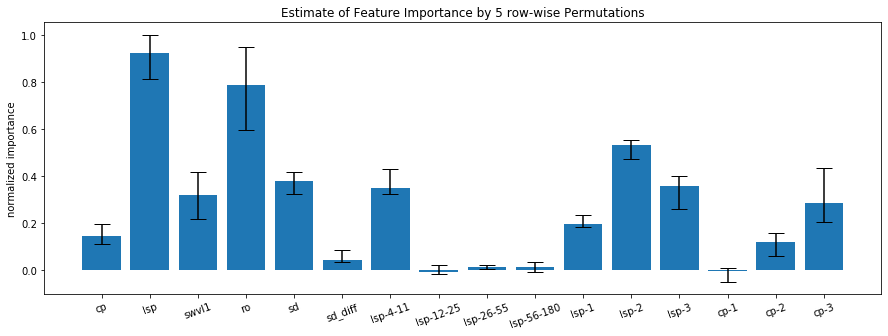

In [240]:
feature_importance_plot(Xda.features, importances)

The importance values are in units of the value returned by the model's `score_func()` function. We trained on differences, so the `get_score_importances()` function returns values that describe the reduction in Mean-Squared-Error of differences of discharge in m$^3$/s. Since this is not quite descriptive, We've normalized the values. 

Lately, the scikit-learn team has released a faster version of a feature importance function. You should check it out [here (sklearn.inspection.permutation_importance)](https://scikit-learn.org/dev/modules/generated/sklearn.inspection.permutation_importance.html).
It currently (Sept. 2019) is in development branch, but might soon be available within a 'stable' release.


## Result of the Hyperparameter Optimization

The lowest RMSE is achieved by the 64 node, 1-layer MLP.

In [148]:
df = pd.read_csv('tdnn-hyperparams4.txt', sep=';', header=0)
df.sort_values('rmse')

,hidden_nodes,dropout,output_dim,epochs,batch_size,loss,rmse,seconds
23,"(64,)",0.25,1,300,90,mse,1665.891043,165.0
12,"(16, 8, 6, 4)",0.10,1,300,90,mse,1674.512973,101.0
1,"(64,)",0.20,1,300,90,mse,1674.834376,176.6
11,"(8, 6, 4, 2)",0.10,1,300,90,mse,1675.585161,120.0
22,"(32,)",0.20,1,300,64,mse,1675.647847,132.0
13,"(64,)",0.40,1,300,90,mse,1677.304704,122.0
0,"(32,)",0.20,1,300,90,mse,1683.486389,152.1
7,"(32,)",0.10,1,300,90,mse,1685.564841,175.1
8,"(64,)",0.10,1,300,90,mse,1687.503179,78.0
6,"(32, 16, 8, 4)",0.20,1,300,90,mse,1690.325191,359.6
